In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np

import xarray as xr

import regionmask

import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat
import matplotlib.patches as mpatches
import datetime

import xesmf as xe

import geopandas
from shapely.geometry import Point, Polygon

import feather

import glob

import calendar

import sys
sys.path.append('../')
import utils
import plotting

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy

In [41]:
ds = {}

In [42]:
ds['merged_NO'] = {}
ds['merged_NO2'] = {}
ds['merged_CH2O'] = {}
ds['merged_SO2'] = {}


In [71]:
for poll in ['merged_NO','merged_NO2','merged_CH2O','merged_SO2']:
    for path in ['nei_NA','normal_NA','nonuc_NA','egrid_NA','epa_NA']:
        ds[poll][path] = xr.open_mfdataset(f'/net/fs11/d0/emfreese/GCrundirs/nuclearproj/{path}/merged_data/{poll}_*.nc', combine = 'by_coords')


In [73]:
for gas in ['NO2','NO','SO2','CH2O']:
    ds_gas[gas] = utils.convert_gases([ds for ds in list(ds[f'merged_{gas}'].values())], [nm for nm in ds[f'merged_{gas}'].keys()], gas)

In [74]:
ds_out = xr.merge([ds_gas[gas] for gas in ['NO2','NO','SO2','CH2O']])

In [75]:
ds_out = ds_out.groupby('time.date').mean(dim = 'time').rename({'date':'time'})

In [76]:
ds_out['time'] = pd.to_datetime(ds_out['time'])


In [41]:
ds = {}

In [42]:
ds['merged_NO'] = {}
ds['merged_NO2'] = {}
ds['merged_CH2O'] = {}
ds['merged_SO2'] = {}


In [71]:
for poll in ['merged_NO','merged_NO2','merged_CH2O','merged_SO2']:
    for path in ['nei_NA','normal_NA','nonuc_NA','egrid_NA','epa_NA']:
        ds[poll][path] = xr.open_mfdataset(f'/net/fs11/d0/emfreese/GCrundirs/nuclearproj/{path}/merged_data/{poll}_*.nc', combine = 'by_coords')


In [73]:
for gas in ['NO2','NO','SO2','CH2O']:
    ds_gas[gas] = utils.convert_gases([ds for ds in list(ds[f'merged_{gas}'].values())], [nm for nm in ds[f'merged_{gas}'].keys()], gas)

In [74]:
ds_out = xr.merge([ds_gas[gas] for gas in ['NO2','NO','SO2','CH2O']])

In [75]:
ds_out = ds_out.groupby('time.date').mean(dim = 'time').rename({'date':'time'})

In [76]:
ds_out['time'] = pd.to_datetime(ds_out['time'])


# Prep O3 and PM2.5 Data

In [121]:
##module load cdo
##create specific file: for file in GEOSChem.SpeciesConc.2016*; do cdo -selvar,SpeciesConc_O3 $file O3_$file; done
###### for file in GEOSChem.AerosolMass.2016*; do cdo -selvar,PM25 $file PM_$file; done
#mkdir ../merged_data
## merge the data: for month in {01,02,03,04,05,06,07,08,09,10,11,12}; do cdo mergetime O3*2016$month*.nc4 ../merged_data/merged_O3_$month.nc ; done
###### for month in {01,02,03,04,05,06,07,08,09,10,11,12}; do cdo mergetime PM*2016$month*.nc4 ../merged_data/merged_PM_$month.nc ; done

## Create a Daily Mean Winter file for each simulation and a Summer Hourly File

In [134]:
for poll in ['merged_PM','merged_O3']:
    for path in ['nei_NA','normal_NA','nonuc_NA','egrid_NA','epa_NA']:
        ds6 = xr.open_dataset(f'/net/fs11/d0/emfreese/GCrundirs/nuclearproj/{path}/merged_data/{poll}_06_hourly.nc')
        ds7 = xr.open_dataset(f'/net/fs11/d0/emfreese/GCrundirs/nuclearproj/{path}/merged_data/{poll}_07_hourly.nc')
        ds8 = xr.open_dataset(f'/net/fs11/d0/emfreese/GCrundirs/nuclearproj/{path}/merged_data/{poll}_08_hourly.nc')
        for idx, ds in zip(['06','07','08'],[ds6, ds7, ds8]):
            ds = ds.groupby('time.date').mean(dim = 'time')
            ds['date'] = pd.to_datetime(ds['date'])
            ds.to_netcdf(f'/net/fs11/d0/emfreese/GCrundirs/nuclearproj/{path}/merged_data/{poll}_{idx}_daily_mean.nc4')
            print(poll, path, idx, 'done')
        ds_JJA = xr.merge([ds6, ds7, ds8])
        #save hourly mean DS
        ds_JJA.to_netcdf(f'/net/fs11/d0/emfreese/GCrundirs/nuclearproj/{path}/merged_data/{poll}_JJA_hourly.nc4')
 
        

merged_O3 normal_NA 06 done
merged_O3 normal_NA 07 done
merged_O3 normal_NA 08 done
merged_O3 nonuc_NA 06 done
merged_O3 nonuc_NA 07 done
merged_O3 nonuc_NA 08 done
merged_O3 egrid_NA 06 done
merged_O3 egrid_NA 07 done
merged_O3 egrid_NA 08 done
merged_O3 epa_NA 06 done
merged_O3 epa_NA 07 done
merged_O3 epa_NA 08 done


## Combine all daily mean data

In [19]:
ds = {}

In [20]:
ds['merged_PM'] = {}
ds['merged_O3'] = {}

In [21]:
for poll in ['merged_PM','merged_O3']:
    for path in ['nei_NA','normal_NA','nonuc_NA','egrid_NA','epa_NA']:
        dsa = xr.open_mfdataset(f'/net/fs11/d0/emfreese/GCrundirs/nuclearproj/{path}/merged_data/{poll}_daily_mean_*.nc', combine = 'by_coords')
        dsb = xr.open_mfdataset(f'/net/fs11/d0/emfreese/GCrundirs/nuclearproj/{path}/merged_data/{poll}_*_daily_mean.nc4', combine = 'nested', concat_dim = 'date')
        dsb.rename({'date':'time'})['time']
        print(poll,path)
        ds[poll][path] = xr.merge([dsa,dsb.rename({'date':'time'})]).groupby('time.date').mean()


merged_PM nei_NA


/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


merged_PM normal_NA


/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


merged_PM nonuc_NA


/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


merged_PM egrid_NA


/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


merged_PM epa_NA


/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


merged_O3 nei_NA


/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


merged_O3 normal_NA


/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


merged_O3 nonuc_NA


/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


merged_O3 egrid_NA


/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


merged_O3 epa_NA


/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [22]:
ds = utils.combine_and_convert_PM_O3([ds for ds in list(ds['merged_O3'].values())], 
                    [ds for ds in list(ds['merged_PM'].values())],
                    [nm for nm in ds['merged_O3'].keys()],
                    [nm for nm in ds['merged_PM'].keys()], 'all_models')

In [23]:
ds = ds.rename({'date':'time'})
ds['time'] = pd.to_datetime(ds['time'])


In [30]:
ds['O3'].attrs = {'units':'ppb'}
ds['PM25'].attrs = {'units':r'$u$g/m3'}

In [32]:
ds.to_netcdf('final_data/ds_PM_O3_daily.nc4')

# Prep NOx, SO2, VOC data

In [ ]:
##module load cdo
##create specific file and merge each of them: 
#for file in GEOSChem.SpeciesConc.2016*; do cdo -selvar,SpeciesConc_CH2O $file CH2O_$file; done && for month in {01,02,03,04,05,06,07,08,09,10,11,12}; do cdo mergetime CH2O*2016$month*.nc4 ../merged_data/merged_CH2O_$month.nc ; done
# && for file in GEOSChem.SpeciesConc.2016*; do cdo -selvar,SpeciesConc_NO $file NO_$file; done && for month in {01,02,03,04,05,06,07,08,09,10,11,12}; do cdo mergetime NO*2016$month*.nc4 ../merged_data/merged_NO_$month.nc ; done
# && for file in GEOSChem.SpeciesConc.2016*; do cdo -selvar,SpeciesConc_NO2 $file NO2_$file; done && for month in {01,02,03,04,05,06,07,08,09,10,11,12}; do cdo mergetime NO2*2016$month*.nc4 ../merged_data/merged_NO2_$month.nc ; done
# && for file in GEOSChem.SpeciesConc.2016*; do cdo -selvar,SpeciesConc_SO2 $file SO2_$file; done && for month in {01,02,03,04,05,06,07,08,09,10,11,12}; do cdo mergetime SO2*2016$month*.nc4 ../merged_data/merged_SO2_$month.nc ; done



In [41]:
ds = {}

In [42]:
ds['merged_NO'] = {}
ds['merged_NO2'] = {}
ds['merged_CH2O'] = {}
ds['merged_SO2'] = {}


In [71]:
for poll in ['merged_NO','merged_NO2','merged_CH2O','merged_SO2']:
    for path in ['nei_NA','normal_NA','nonuc_NA','egrid_NA','epa_NA']:
        ds[poll][path] = xr.open_mfdataset(f'/net/fs11/d0/emfreese/GCrundirs/nuclearproj/{path}/merged_data/{poll}_*.nc', combine = 'by_coords')


In [73]:
for gas in ['NO2','NO','SO2','CH2O']:
    ds_gas[gas] = utils.convert_gases([ds for ds in list(ds[f'merged_{gas}'].values())], [nm for nm in ds[f'merged_{gas}'].keys()], gas)

In [74]:
ds_out = xr.merge([ds_gas[gas] for gas in ['NO2','NO','SO2','CH2O']])

In [75]:
ds_out = ds_out.groupby('time.date').mean(dim = 'time').rename({'date':'time'})

In [76]:
ds_out['time'] = pd.to_datetime(ds_out['time'])


In [77]:
#sum our NO2 and NO to get NOx
ds_out['NOx'] = (ds_out['NO'] + ds_out['NO2'])

In [78]:
ds_out.to_netcdf('final_data/ds_NOX_SO2_CH2O_daily.nc4')

# Prep HEMCO Emissions Data

ds_MODEL = xr.open_mfdataset('/net/fs11/d0/emfreese/GCrundirs/nuclearproj/normal_NA/OutputDir/HEMCO_diagnostics.2016*.nc', combine = 'by_coords')
ds_egrid = xr.open_mfdataset('/net/fs11/d0/emfreese/GCrundirs/nuclearproj/egrid_NA/OutputDir/HEMCO_diagnostics.2016*.nc', combine = 'by_coords')



ds_MODEL = ds_MODEL.isel(lev = 0)
ds_egrid = ds_egrid.isel(lev = 0)

ds = xr.concat([ds_egrid, ds_NEI, ds_MODEL, ds_epa], pd.Index(['egrid', 'NEI', 'MODEL','epa'], name='model_name'))

ds.to_netcdf('final_data/HEMCO_emis.nc4')

# US-EGO Generation and Emissions Data

#### Definition of Plant type (in 2016 EPA egrid TSD section 5)
The fuel category for the primary fuel of the plant. This field is “COAL” if the plant’s primary fuel is derived from coal (fuel type = BIT, COG, LIG, RC, SGC, SUB, WC), “OIL” if it is derived from oil (DFO, JF, KER, PC, RFO, WO), “GAS” if it is derived from gas (BU, NG, PG), “OFSL” if it is another fossil fuel (BFG, OG, TDF), “NUCLEAR” if it is derived from nuclear (NUC), “HYDRO” if it is derived from hydro power (WAT), “SOLAR” if it is derived from solar power, (SUN), “WIND” if it is derived from wind power (WND), “GEOTHERMAL” if it is derived from geothermal power (GEO), “OTHF” if it is derived from waste heat/unknown/purchased (MWH, OTH, PRG, PUR, WH), and “BIOMASS” if it is derived from biomass sources (AB, BLQ, LFG, MSW, OBG, OBL, OBS, SLW, WDL, WDS).

In [47]:
##### import files and change hydro #####

###get ORIS, plant type, and Region Name from our modified generation file
oris_nonuc_df = pd.read_csv('../optimization_model/good_model_inputs/inputs_gen_no-nuclear_all-generators_20k-new_name.csv',usecols=[1,2,4,5,8,22,23,24,25])
oris_normal_df = pd.read_csv('../optimization_model/good_model_inputs/inputs_gen_normal.csv',usecols=[1,2,4,5,8,22,23,24,25])
oris_nocoal_df = pd.read_csv('../optimization_model/good_model_inputs/inputs_gen_no-nuclear_no_coal.csv',usecols=[1,2,4,5,8,22,23,24,25])

oris_nonuc_df.loc[oris_nonuc_df['FuelType'] == 'Pumps', 'FuelType'] = 'Hydro' #change pumps to hydro label
oris_normal_df.loc[oris_normal_df['FuelType'] == 'Pumps', 'FuelType'] = 'Hydro' #change pumps to hydro label
oris_nocoal_df.loc[oris_nocoal_df['FuelType'] == 'Pumps', 'FuelType'] = 'Hydro' #change pumps to hydro label

###import egrid generation data and modify the index to be ORISCode
egrid_df_raw = pd.read_excel('../raw_data/egrid2016_data.xlsx',sheet_name='GEN16', usecols='D, J, L')
egrid = egrid_df_raw.drop(egrid_df_raw.index[0]).rename(columns={'DOE/EIA ORIS plant or facility code':'ORISCode'})
#change those with no capacity to 1 (so that our capacity factor calculation doesn't fail)
egrid.loc[egrid['Generator nameplate capacity (MW)'] == 0, 'Generator nameplate capacity (MW)'] = 1
#calculate the capacity factor of generation in egrid
egrid['egrid_capafactor'] = egrid['Generator annual net generation (MWh)'] / (8760 * egrid['Generator nameplate capacity (MW)']) 

###import the generation data from our optimization
gen_normal_df=feather.read_dataframe('../optimization_model/outputs/gen_normal.feather')

###import the generation data from our optimization
gen_nonuc_df=feather.read_dataframe('../optimization_model/outputs/gen_no-nuclear.feather')

###import the generation data from our optimization
gen_nocoal_df=feather.read_dataframe('../optimization_model/outputs/gen_no-nuclear_no-coal.feather')


### import the plant type from our egrid dataset
planttype_df_raw=pd.read_excel('../raw_data/egrid2016_data.xlsx',sheet_name='PLNT16', usecols='D, W')
planttype_df=planttype_df_raw.drop(egrid_df_raw.index[0]).rename(columns={'DOE/EIA ORIS plant or facility code':'ORISCode', 
                                                                       'Plant primary coal/oil/gas/ other fossil fuel category':'planttype'})



In [48]:
##### change index and convert to xarray #####

#group by ORIS code and make a date and ORIS code multi index
gen_nonuc_df = pd.concat([gen_nonuc_df,oris_nonuc_df['ORISCode']], axis = 1).groupby(['ORISCode']).sum()
gen_normal_df = pd.concat([gen_normal_df,oris_normal_df['ORISCode']], axis = 1).groupby(['ORISCode']).sum()
gen_nocoal_df = pd.concat([gen_nocoal_df,oris_nocoal_df['ORISCode']], axis = 1).groupby(['ORISCode']).sum()

gen_normal_df = gen_normal_df.stack()
gen_nonuc_df = gen_nonuc_df.stack()
gen_nocoal_df = gen_nocoal_df.stack()

gen_nonuc_df.index.names = (['ORISCode','date'])
gen_normal_df.index.names = (['ORISCode','date'])
gen_nocoal_df.index.names = (['ORISCode','date'])


egrid = egrid.groupby('ORISCode').sum().drop(columns = 'egrid_capafactor') #drop capacity factor because that isn't the sum
 
planttype=planttype_df.set_index(['ORISCode'])
planttype_sort=planttype.sort_values(by="ORISCode")

egrid_planttype_df = pd.concat((egrid,planttype_sort),axis=1)

#convert to xarray datasets
oris_nonuc_ds = oris_nonuc_df.to_xarray()
oris_normal_ds = oris_normal_df.to_xarray()
oris_nocoal_ds = oris_nocoal_df.to_xarray()

egrid_planttype_ds = egrid_planttype_df.to_xarray()

gen_normal_ds = gen_normal_df.to_xarray()
gen_nonuc_ds = gen_nonuc_df.to_xarray()
gen_nocoal_ds = gen_nocoal_df.to_xarray()

In [49]:
#### combine our egrid and generation info for no nuclear and normal models ####
nonuc_gmodel_egrid_ds = utils.combine_egrid_generation(oris_nonuc_ds, gen_nonuc_ds, egrid_planttype_ds)
normal_gmodel_egrid_ds = utils.combine_egrid_generation(oris_normal_ds, gen_normal_ds, egrid_planttype_ds)
nocoal_gmodel_egrid_ds = utils.combine_egrid_generation(oris_nocoal_ds, gen_nocoal_ds, egrid_planttype_ds)

gmodel_egrid_raw_ds = xr.concat([nonuc_gmodel_egrid_ds, normal_gmodel_egrid_ds,nocoal_gmodel_egrid_ds], 
                                pd.Index(['nonuc_model','normal_model','nonuc_nocoal_model'], name='model_name'))

In [50]:
#### fix datetime and add dec 31st at the 23rd hour ####

###create a dict for dec 31st 23rd hour (just copy the dec 31 22nd hour data over)
dec23_ds = gmodel_egrid_raw_ds.copy().isel(date = [-1])
#change date to datetime for the 23rd hour
dec23_ds['date'] = [datetime.datetime(2017,12,31,23,0)]

###change all dates to datetime
#make a list of dates for the year
base = datetime.datetime(2017, 1, 1) #base date
date_list = [base + datetime.timedelta(hours=x) for x in range(8759)] #loop through all hours but the final one (we will add it in above)
date_list

gmodel_egrid_raw_ds['date'] = date_list
gmodel_egrid_ds = xr.merge([gmodel_egrid_raw_ds, dec23_ds])

#### Note:

To convert our generation in MWh to get the emissions in kg/sec, we use the following (and making sure our emissions rates are in kg/sec)

$\text{Mwh}/3600sec -> (\text{Mw}/s) * kg/\text{Mw} -> kg/s$


In [51]:
###### add NOx, SO2, CO2, CH4 emissions to gmodel_egrid dataset ######

no_mult = 0.8544304 # NO/NOx as estimated from NEI2011 inventory
no2_mult = 1 - 0.8544304 # NO2/NOx as estimated from NEI2011 inventory

### process our emissions by multiplying generation* emissions factors
gmodel_egrid_ds['model_NO_rate']  = no_mult * gmodel_egrid_ds['modelgeneration']/3600 * gmodel_egrid_ds['PLNOXRTA']
gmodel_egrid_ds['model_NO2_rate']  = no2_mult * gmodel_egrid_ds['modelgeneration']/3600 * gmodel_egrid_ds['PLNOXRTA']
gmodel_egrid_ds['model_SO2_rate']  =  gmodel_egrid_ds['modelgeneration']/3600 * gmodel_egrid_ds['PLSO2RTA']
gmodel_egrid_ds['model_CO2_rate']  =  gmodel_egrid_ds['modelgeneration']/3600 * gmodel_egrid_ds['PLCO2RTA']
gmodel_egrid_ds['model_CH4_rate']  =  gmodel_egrid_ds['modelgeneration']/3600 * gmodel_egrid_ds['PLCH4RTA']

gmodel_egrid_ds['egrid_annual_NO_rate']  = no_mult * gmodel_egrid_ds['annual_egridgeneration']/3600 * gmodel_egrid_ds['PLNOXRTA']
gmodel_egrid_ds['egrid_annual_NO2_rate']  = no2_mult * gmodel_egrid_ds['annual_egridgeneration']/3600 * gmodel_egrid_ds['PLNOXRTA']
gmodel_egrid_ds['egrid_annual_SO2_rate']  =  gmodel_egrid_ds['annual_egridgeneration']/3600 * gmodel_egrid_ds['PLSO2RTA']
gmodel_egrid_ds['egrid_annual_CO2_rate']  =  gmodel_egrid_ds['annual_egridgeneration']/3600 * gmodel_egrid_ds['PLCO2RTA']
gmodel_egrid_ds['egrid_annual_CH4_rate']  =  gmodel_egrid_ds['annual_egridgeneration']/3600 * gmodel_egrid_ds['PLCH4RTA']

##### annual generation in original dataset ######
gmodel_egrid_ds['annual_modelgeneration'] = gmodel_egrid_ds['modelgeneration'].groupby('ORISCode').sum(dim = 'date')

In [52]:
####### create new datasets for region and fuel type grouped data, add annual generation to normal ds ######

###list of pollutants
pollutants = ['NO','NO2','SO2','CO2','CH4']

def create_grouped_ds(grouper, model):
    grouped_ds = gmodel_egrid_ds.copy().sel(model_name = model).groupby(grouper).sum()
    grouped_ds = grouped_ds.drop(['model_capafactor','PLCH4RTA','PLCO2RTA','PLNOXRTA','PLSO2RTA','PLN2ORTA'])
    return(grouped_ds)

###create datasets of grouped fuel type and region name, combine
nonuc_fueltype_grouped_ds = create_grouped_ds('fueltype', 'nonuc_model')
normal_fueltype_grouped_ds = create_grouped_ds('fueltype', 'normal_model')
nocoal_fueltype_grouped_ds = create_grouped_ds('fueltype', 'nonuc_nocoal_model')

nonuc_regionname_grouped_ds = create_grouped_ds('regionname', 'nonuc_model')
normal_regionname_grouped_ds = create_grouped_ds('regionname', 'normal_model')
nocoal_regionname_grouped_ds = create_grouped_ds('regionname', 'nonuc_nocoal_model')

fueltype_grouped_ds = xr.concat([nonuc_fueltype_grouped_ds, normal_fueltype_grouped_ds,nocoal_fueltype_grouped_ds], 
                                pd.Index(['nonuc_model','normal_model','nonuc_nocoal_model'], name='model_name'))
regionname_grouped_ds = xr.concat([nonuc_regionname_grouped_ds, normal_regionname_grouped_ds, nocoal_regionname_grouped_ds], 
                                  pd.Index(['nonuc_model','normal_model','nonuc_nocoal_model'], name='model_name'))

In [53]:
#add annual emissions of each pollutant
for pollutant in pollutants:
    regionname_grouped_ds[f'model_annual_{pollutant}_conc'] = (regionname_grouped_ds[f'model_{pollutant}_rate']*3600).sum(dim = 'date')
    fueltype_grouped_ds[f'model_annual_{pollutant}_conc'] = (fueltype_grouped_ds[f'model_{pollutant}_rate']*3600).sum(dim = 'date')
    gmodel_egrid_ds[f'model_annual_{pollutant}_conc'] = (gmodel_egrid_ds[f'model_{pollutant}_rate']*3600).sum(dim = 'date')

    regionname_grouped_ds[f'egrid_annual_{pollutant}_conc'] = (regionname_grouped_ds[f'egrid_annual_{pollutant}_rate']*3600)
    fueltype_grouped_ds[f'egrid_annual_{pollutant}_conc'] = (fueltype_grouped_ds[f'egrid_annual_{pollutant}_rate']*3600)
    gmodel_egrid_ds[f'egrid_annual_{pollutant}_conc'] = (gmodel_egrid_ds[f'egrid_annual_{pollutant}_rate']*3600)

#add ratio of difference in emissions normal-nonuc/ difference in generation normal-nonuc to the nonuc dataset
for pollutant in pollutants:
    fueltype_grouped_ds.sel(model_name = 'nonuc_model')[f'normal-nonuc_{pollutant}-gen_ratio'] = (fueltype_grouped_ds.sel(model_name = 'normal_model')[f'model_annual_{pollutant}_conc']-
                                                                       fueltype_grouped_ds.sel(model_name = 'nonuc_model')[f'model_annual_{pollutant}_conc'])/(fueltype_grouped_ds.sel(model_name = 'normal_model')['annual_modelgeneration']-
                                                                                                                             fueltype_grouped_ds.sel(model_name = 'nonuc_model')['annual_modelgeneration'])
    regionname_grouped_ds.sel(model_name = 'nonuc_model')[f'normal-nonuc_{pollutant}-gen_ratio'] = (regionname_grouped_ds.sel(model_name = 'normal_model')[f'model_annual_{pollutant}_conc']-
                                                                         regionname_grouped_ds.sel(model_name = 'nonuc_model')[f'model_annual_{pollutant}_conc'])/(regionname_grouped_ds.sel(model_name = 'normal_model')['annual_modelgeneration']-
                                                                                                                                 regionname_grouped_ds.sel(model_name = 'nonuc_model')['annual_modelgeneration'])

    fueltype_grouped_ds.sel(model_name = 'nonuc_nocoal_model')[f'normal-nonuc_nocoal_{pollutant}-gen_ratio'] = (fueltype_grouped_ds.sel(model_name = 'normal_model')[f'model_annual_{pollutant}_conc']-
                                                                       fueltype_grouped_ds.sel(model_name = 'nonuc_model')[f'model_annual_{pollutant}_conc'])/(fueltype_grouped_ds.sel(model_name = 'normal_model')['annual_modelgeneration']-
                                                                                                                             fueltype_grouped_ds.sel(model_name = 'nonuc_nocoal_model')['annual_modelgeneration'])
    regionname_grouped_ds.sel(model_name = 'nonuc_nocoal_model')[f'normal-nonuc_nocoal_{pollutant}-gen_ratio'] = (regionname_grouped_ds.sel(model_name = 'normal_model')[f'model_annual_{pollutant}_conc']-
                                                                         regionname_grouped_ds.sel(model_name = 'nonuc_model')[f'model_annual_{pollutant}_conc'])/(regionname_grouped_ds.sel(model_name = 'normal_model')['annual_modelgeneration']-
                                                                                                                                 regionname_grouped_ds.sel(model_name = 'nonuc_nocoal_model')['annual_modelgeneration'])



In [54]:
#### add attributes ####
for pollutant in pollutants:
    if pollutant == 'NO2' or 'NO':
                gmodel_egrid_ds[f'PLNOXRTA'].attrs['units'] = 'kg/Mwh'
    else:
        gmodel_egrid_ds[f'PL{pollutant}RTA'].attrs['units'] = 'kg/Mwh'
    for idx, ds in enumerate([regionname_grouped_ds, fueltype_grouped_ds, gmodel_egrid_ds]):
        ds[f'model_{pollutant}_rate'].attrs['units'] = 'kg/s'
        ds[f'modelgeneration'].attrs['units'] = 'Mwh'
        for typem in ['egrid','model']:
            ds[f'annual_{typem}generation'].attrs['units'] = 'Mwh'
            ds[f'{typem}_annual_{pollutant}_conc'].attrs['units'] = 'kg'
        ds[f'egrid_annual_{pollutant}_rate'].attrs['units'] = 'kg/s'
        ds.attrs['group'] = ['Region','Fuel Type','All'][idx]
        
        

In [55]:
##### save datasets #####
### Final datasets to save are: gmodel_egrid, fueltype_grouped_ds, regionname_grouped_ds
xr.Dataset.to_zarr(regionname_grouped_ds, './final_data/regionname_grouped_emissions_ds.zarr', mode = 'w') #save the dataset 
xr.Dataset.to_zarr(fueltype_grouped_ds, './final_data/fueltype_grouped_emissions_ds.zarr', mode = 'w') #save the dataset 
xr.Dataset.to_zarr(gmodel_egrid_ds, './final_data/gmodel_egrid_emissions_ds.zarr', mode = 'w') #save the dataset 
### datasets partway to save are:
xr.Dataset.to_zarr(oris_nonuc_ds, './final_data/oris_nonuc_ds.zarr', mode = 'w') #save the dataset 
xr.Dataset.to_zarr(oris_nocoal_ds, './final_data/oris_nonuc_coal_ds.zarr', mode = 'w') #save the dataset 
xr.Dataset.to_zarr(oris_normal_ds, './final_data/oris_normal_ds.zarr', mode = 'w') #save the dataset 
xr.Dataset.to_zarr(egrid_planttype_ds, './final_data/egrid_ds.zarr', mode = 'w') #save the dataset 

# MERRA2 RH and T

In [ ]:
##### import MERRA2 datasets for RH and T #####

#import 
T_ds = xr.open_mfdataset('../../MERRA2/2016/GEOS_0.5x0.625_NA/MERRA2/2016/*/MERRA2.2016*.A1.05x0625.NA.nc4', combine = 'by_coords')
RH_ds = xr.open_mfdataset('../../MERRA2/2016/GEOS_0.5x0.625_NA/MERRA2/2016/*/MERRA2.2016*.A3dyn.05x0625.NA.nc4', combine = 'by_coords')

#reduce datasets just to T and RH
T_ds = T_ds['TS']
RH_ds = RH_ds['RH']

In [ ]:
##### Select T and RH in the bounds of our US lat and lon #####
T = {}
RH = {}
for region in utils.lat_lon_dict.keys():
    T[region] = {}
    T[region] = T_ds.sel(
        lon = slice(utils.lat_lon_dict[region][0], utils.lat_lon_dict[region][1]), 
        lat = slice(utils.lat_lon_dict[region][2],utils.lat_lon_dict[region][3])
    ).groupby('time.season').mean()
    RH[region] = {}
    RH[region] = RH_ds.sel(
        lon = slice(utils.lat_lon_dict[region][0], utils.lat_lon_dict[region][1]), 
        lat = slice(utils.lat_lon_dict[region][2],utils.lat_lon_dict[region][3])
    ).groupby('time.season').mean()

In [ ]:
##### Calculate seasonal mean RH and T by region #####
T_seasonal_mean = {}
RH_seasonal_mean = {}
for region in utils.lat_lon_dict.keys():
    T_seasonal_mean[region] = {}
    RH_seasonal_mean[region] = {}
    for seasons in ['DJF','JJA','MAM','SON']:
        T_seasonal_mean[region][seasons] = T[region].sel(season = seasons).mean().values
        RH_seasonal_mean[region][seasons] = RH[region].sel(season = seasons).mean().values

In [ ]:
##### convert to dataframes ##### 

T_df = pd.DataFrame.from_dict({(i,j): T_seasonal_mean[i][j]
                            for i in T_seasonal_mean.keys() 
                            for j in T_seasonal_mean[i].keys()},
                            orient='index', columns = ['T'])
T_df.index = pd.MultiIndex.from_tuples(T_df.index)

RH_df = pd.DataFrame.from_dict({(i,j): RH_seasonal_mean[i][j]
                            for i in RH_seasonal_mean.keys() 
                            for j in RH_seasonal_mean[i].keys()},
                            orient='index', columns = ['RH'])
RH_df.index = pd.MultiIndex.from_tuples(RH_df.index)



In [ ]:
##### merge dataframes #####
RH_T_df = pd.merge(
    T_df, RH_df, 
    left_index=True, right_index=True)

In [ ]:
##### save dataframe #####
pd.DataFrame.to_csv(RH_T_df, './data/RH_T.csv')

# Observational Data

## EPA Observational data
data is from https://aqs.epa.gov/aqsweb/airdata/download_files.html
for the year 2016
choosing O3, NO, SO2, PM25 (FEM/FRM)


In [2]:
##module load cdo
##create specific file and merge each of them: 
#for file in GEOSChem.AerosolMass.2016*; do cdo -selvar,AerMassNIT $file NIT_$file; done && for month in {01,02,03,04,05,06,07,08,09,10,11,12}; do cdo mergetime NIT*2016$month*.nc4 ../merged_data/merged_NIT_$month.nc ; done && for file in GEOSChem.SpeciesConc.2016*; do cdo -selvar,SpeciesConc_SO4 $file SO4_$file; done && for month in {01,02,03,04,05,06,07,08,09,10,11,12}; do cdo mergetime SO4*2016$month*.nc4 ../merged_data/merged_SO4_$month.nc ; done



In [3]:
ds = {}
ds['merged_NIT'] = {}
ds['merged_SO4'] = {}
for poll in ['merged_NIT','merged_SO4']:
    for path in ['nei_NA','normal_NA','nonuc_NA','egrid_NA','epa_NA']:
        ds[poll][path] = xr.open_mfdataset(f'/net/fs11/d0/emfreese/GCrundirs/nuclearproj/{path}/merged_data/{poll}_*.nc', combine = 'by_coords')


In [4]:
ds_gas = {}
ds_gas['SO4'] = utils.convert_gases([ds for ds in list(ds[f'merged_SO4'].values())], [nm for nm in ds[f'merged_SO4'].keys()], 'SO4')
ds_gas['NIT'] = utils.convert_aerosol([ds for ds in list(ds[f'merged_NIT'].values())], [nm for nm in ds[f'merged_NIT'].keys()], 'NIT')

In [5]:


ds_out = xr.merge([ds_gas[gas] for gas in ['NIT','SO4']])
ds_out = ds_out.groupby('time.date').mean(dim = 'time').rename({'date':'time'})
ds_out['time'] = pd.to_datetime(ds_out['time'])


In [6]:
ds2 = xr.open_dataset('final_data/ds_NOX_SO2_CH2O_daily.nc4')
ds3 = xr.open_dataset('final_data/ds_PM_O3_daily.nc4')

In [7]:
poll_ds = ds_out.merge(ds2)
poll_ds = poll_ds.merge(ds3.drop('lev_bnds'))

In [8]:
EPA_obs_df = utils.import_and_edit_EPAobs('../../GEOS_CHEM/obs_data/daily*.csv')

/net/fs11/d0/emfreese/grid_model/ego_nonuclear_project/../utils.py:271: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  EPA_obs_df = EPA_obs_df.loc[(EPA_obs_df['Latitude'].between(24,50,inclusive = True)) & (EPA_obs_df['Longitude'].between(-130,-60,inclusive = True))]


## IMPROVE Observational data

mw_dict = {'ammNO3': 80.043,
           'ammSO4': 132.14} #g/mol 
g_ug = 1e6

for species in mw_dict.keys():
    ammon_df[f'{species}f:Value'] *= mw_dict[species] * g_ug

In [9]:
pm_df = utils.import_IMPROVE('../../GEOS_CHEM/obs_data/IMPROVE_2016_PM.txt', 'PM25', 'MF')
s_df = utils.import_IMPROVE('../../GEOS_CHEM/obs_data/IMPROVE_2016_Sulfate.txt', 'SO4', 'SO4f')
n_df = utils.import_IMPROVE('../../GEOS_CHEM/obs_data/IMPROVE_2016_Nitrate.txt', 'NIT', 'NO3f')
ammon_df = utils.import_IMPROVE('../../GEOS_CHEM/obs_data/IMPROVE_2016_ammonia.txt', 'NH4', 'NH4f')
oc_df = utils.import_IMPROVE('../../GEOS_CHEM/obs_data/IMPROVE_2016_OC.txt', 'OC', 'ECf')

IMPROVE_df = pd.concat([pm_df, s_df, n_df,oc_df, ammon_df], axis = 0) #concatenate all dataframes and reset the index
IMPROVE_df['Date'] = pd.to_datetime(IMPROVE_df['Date']) #change to datetime
IMPROVE_df = IMPROVE_df.loc[IMPROVE_df['Arithmetic Mean'] >= 0] #get rid of -999 readings where there is no data
IMPROVE_df = IMPROVE_df.loc[(IMPROVE_df['Latitude'].between(24,50,inclusive = True)) & (IMPROVE_df['Longitude'].between(-130,-60,inclusive = True))]


/tmp/ipykernel_4122429/2986938097.py:10: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  IMPROVE_df = IMPROVE_df.loc[(IMPROVE_df['Latitude'].between(24,50,inclusive = True)) & (IMPROVE_df['Longitude'].between(-130,-60,inclusive = True))]


## Lists/Dicts of Variables

In [10]:
#define Lat and Lon of the nested grid US
levels_dict = {'PM25':np.arange(0., 20., .5), 'SO2':np.arange(0., 5., .1), 
               'NO2':np.arange(0., 5., .1), 'NOx':np.arange(0., 5., .1), 'O3':np.arange(0., 70., 1.),
               'dif':np.arange(-.3, .31, .01), 'regional_dif':np.arange(-1.5, 1.51, .01)}

## Interpolate data to get GC run data at observational points

### EPA Interpolation

In [16]:
### interpolate data for EPA
interp_EPA_df = pd.DataFrame(columns=['Arithmetic Mean', 'Longitude', 'Latitude','model_name','species','date'])

for model in ['egrid_NA', 'nei_NA', 'epa_NA', 'normal_NA']:
    print(model, end = ', ')
    for species in ['PM25', 'SO2', 'NO2', 'O3']:
        print(species, end = ', ')
        for month in np.arange(1,13):
            print(month, end = ', ')
            #data selected for date
            data = poll_ds.sel(model_name = model)[f'{species}'].groupby('time.month').mean().sel(month = month)
            
            #new lat and lon in radians
            lats_new = EPA_obs_df.loc[(EPA_obs_df['species'] == species)]['Latitude'].unique()
            lons_new = EPA_obs_df.loc[(EPA_obs_df['species'] == species)]['Longitude'].unique()
            
            #interpolation function
            interp_data = []
            for idx in range(lats_new.size):
                interp_data.append(data.sel(lat=lats_new[idx], lon=lons_new[idx], method='nearest').values.item())
            tmp_df = pd.DataFrame({'Arithmetic Mean':interp_data, 'Longitude':lons_new, 'Latitude':lats_new, 'model_name': model, 'species': species, 'date': month})
            interp_EPA_df = interp_EPA_df.append(tmp_df, sort=False, ignore_index=True)

    

egrid_NA, PM25, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, SO2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, NO2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, O3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, nei_NA, PM25, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, SO2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, NO2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, O3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, epa_NA, PM25, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, SO2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, NO2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, O3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, normal_NA, PM25, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, SO2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, NO2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, O3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 

In [17]:
for i in range(0, len(interp_EPA_df)):
    interp_EPA_df.loc[i,('date')] = datetime.datetime(2016,interp_EPA_df['date'][i],calendar.monthrange(2016,interp_EPA_df['date'][i])[1])

### IMPROVE Interpolation

In [13]:
### interpolate data for EPA
interp_IMPROVE_df = pd.DataFrame(columns=['Arithmetic Mean', 'Longitude', 'Latitude','model_name','species','date'])

for model in ['egrid_NA', 'nei_NA', 'epa_NA', 'normal_NA']:
    print(model, end = ', ')
    for species in ['PM25','NIT','SO4']:
        print(species, end = ', ')
        for month in np.arange(1,13):
            print(month, end = ', ')
            #data selected for date
            data = poll_ds.sel(model_name = model)[f'{species}'].groupby('time.month').mean().sel(month = month)
            
            #new lat and lon in radians
            if species == 'NH3': #interpolating NH3 to get it for our ISORROPIA total NH4 and NH3
                lats_new = IMPROVE_df.loc[(IMPROVE_df['species'] == 'NH4')]['Latitude'].unique()
                lons_new = IMPROVE_df.loc[(IMPROVE_df['species'] == 'NH4')]['Longitude'].unique()
            if species == 'HNO3': #interpolating NH3 to get it for our ISORROPIA total HNO3 and NIT
                lats_new = IMPROVE_df.loc[(IMPROVE_df['species'] == 'NIT')]['Latitude'].unique()
                lons_new = IMPROVE_df.loc[(IMPROVE_df['species'] == 'NIT')]['Longitude'].unique()
            if species == 'TotalOC':
                lats_new = IMPROVE_df.loc[(IMPROVE_df['species'] == 'OC')]['Latitude'].unique()
                lons_new = IMPROVE_df.loc[(IMPROVE_df['species'] == 'OC')]['Longitude'].unique()
            else:
                lats_new = IMPROVE_df.loc[(IMPROVE_df['species'] == species)]['Latitude'].unique()
                lons_new = IMPROVE_df.loc[(IMPROVE_df['species'] == species)]['Longitude'].unique()
            #interpolation function
            interp_data = []
            for idx in range(lats_new.size):
                interp_data.append(data.sel(lat=lats_new[idx], lon=lons_new[idx], method='nearest').values.item())
            tmp_df = pd.DataFrame({'Arithmetic Mean':interp_data, 'Longitude':lons_new, 'Latitude':lats_new, 'model_name': model, 'species': species, 'date': month})
            interp_IMPROVE_df = interp_IMPROVE_df.append(tmp_df, sort=False, ignore_index=True)



egrid_NA, PM25, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, NIT, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, SO4, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, nei_NA, PM25, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, NIT, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, SO4, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, epa_NA, PM25, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, NIT, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, SO4, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, normal_NA, PM25, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, NIT, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, SO4, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 

In [14]:
for i in range(0, len(interp_IMPROVE_df)):
    interp_IMPROVE_df.loc[i,('date')] = datetime.datetime(2016,interp_IMPROVE_df['date'][i],calendar.monthrange(2016,interp_IMPROVE_df['date'][i])[1])

## Create a monthly observational dataframe

In [18]:
IMPROVE_df = IMPROVE_df.rename(columns = {'Date':'date'})

In [19]:
def create_monthly_obs_df(obs_df):
    
    #create the 'geometries' for each lat and lon
    gdf = geopandas.GeoDataFrame(
    obs_df, geometry=geopandas.points_from_xy(obs_df.Longitude, obs_df.Latitude))
    geometries = gdf['geometry'].apply(lambda x: x.wkt).values
    #add to the dataset
    obs_df['geometry'] = geometries
    obs_df.index = obs_df['date']

    #group by month and geometry
    monthly_obs_df = pd.DataFrame(columns = ['Arithmetic Mean','Latitude','Longitude', 'geometry','species', 'date'])
    geometry = geometries[0]
    for geometry in np.unique(np.unique(obs_df['geometry'])):
        for species in np.unique(obs_df['species'].values):
            lat = obs_df.loc[(obs_df['geometry'] == geometry) & (obs_df['species'] == species)].groupby(pd.Grouper(freq='M'))['Latitude'].first().values
            lon = obs_df.loc[(obs_df['geometry'] == geometry) & (obs_df['species'] == species)].groupby(pd.Grouper(freq='M'))['Longitude'].first().values
            data = obs_df.loc[(obs_df['geometry'] == geometry) & (obs_df['species'] == species)].groupby(pd.Grouper(freq='M'))['Arithmetic Mean'].mean()
            tmp_df = pd.DataFrame({'Arithmetic Mean': data.values, 'Latitude':lat, 'Longitude':lon, 
                                   'geometry':geometry, 'species': species, 'date': data.index})
            monthly_obs_df = monthly_obs_df.append(tmp_df, sort=False, ignore_index=True)
    return(monthly_obs_df)


In [20]:
monthly_IMPROVE_df = create_monthly_obs_df(IMPROVE_df)
monthly_EPA_df = create_monthly_obs_df(EPA_obs_df)

## Add Region Names to the dataframes

In [21]:
#add region to the dataframes based on lat_lon dictionary
for df in [monthly_EPA_df, interp_EPA_df, EPA_obs_df, IMPROVE_df, interp_IMPROVE_df,monthly_IMPROVE_df]: 
    df['Region'] = 'a'
    for region in ['SE_lat_lon', 'NW_lat_lon', 'NE_lat_lon', 'MW_lat_lon', 'SW_lat_lon']:
        df.loc[(df['Longitude'].between(utils.lat_lon_dict[region][0], utils.lat_lon_dict[region][1], inclusive = True)) & 
            (df['Latitude'].between(utils.lat_lon_dict[region][2], utils.lat_lon_dict[region][3], inclusive = True)), 'Region'] = region

/tmp/ipykernel_4122429/666539968.py:5: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  df.loc[(df['Longitude'].between(utils.lat_lon_dict[region][0], utils.lat_lon_dict[region][1], inclusive = True)) &
/tmp/ipykernel_4122429/666539968.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  (df['Latitude'].between(utils.lat_lon_dict[region][2], utils.lat_lon_dict[region][3], inclusive = True)), 'Region'] = region


## Save the dataframes

In [22]:
interp_EPA_df.to_csv('./final_data/interp_EPA_df.csv', date_format='%Y%m%d', index=False)
EPA_obs_df.to_csv('./final_data/EPA_obs_df.csv', date_format='%Y%m%d', index=False)
monthly_EPA_df.to_csv('./final_data/EPA_monthly_obs_df.csv', date_format='%Y%m%d', index=False)
IMPROVE_df.to_csv('./final_data/IMPROVE_df.csv', date_format='%Y%m%d', index=False)
interp_IMPROVE_df.to_csv('./final_data/interp_IMPROVE_df.csv', date_format='%Y%m%d', index=False)
monthly_IMPROVE_df.to_csv('./final_data/IMPROVE_monthly_obs_df.csv', date_format='%Y%m%d', index=False)

# Make O3 Dataset Hourly

In [1]:
for poll in ['merged_PM','merged_O3']:
    for path in ['nei_NA','normal_NA','nonuc_NA','egrid_NA','epa_NA']:
        ds6 = xr.open_dataset(f'/net/fs11/d0/emfreese/GCrundirs/nuclearproj/{path}/merged_data/{poll}_06_hourly.nc')
        ds7 = xr.open_dataset(f'/net/fs11/d0/emfreese/GCrundirs/nuclearproj/{path}/merged_data/{poll}_07_hourly.nc')
        ds8 = xr.open_dataset(f'/net/fs11/d0/emfreese/GCrundirs/nuclearproj/{path}/merged_data/{poll}_08_hourly.nc')
        for idx, ds in zip(['06','07','08'],[ds6, ds7, ds8]):
            ds = ds.groupby('time.date').mean(dim = 'time')
            ds['date'] = pd.to_datetime(ds['date'])
            ds.to_netcdf(f'/net/fs11/d0/emfreese/GCrundirs/nuclearproj/{path}/merged_data/{poll}_{idx}_daily_mean.nc4')
            print(poll, path, idx, 'done')
        ds_JJA = xr.merge([ds6, ds7, ds8])
        #save hourly mean DS
        ds_JJA.to_netcdf(f'/net/fs11/d0/emfreese/GCrundirs/nuclearproj/{path}/merged_data/{poll}_JJA_hourly.nc4')
 
        

NameError: name 'xr' is not defined

# Health Calculations
Using raster = 4 to get the 2015 GWP population density

In [2]:
#### import our pollution datasets ####
ds_PM = xr.open_dataset("./final_data/ds_PM_O3_daily.nc4")


In [3]:
ds_import = {}
for path in ['nei_NA','normal_NA','nonuc_NA','egrid_NA','epa_NA']:
    ds_import[path] = xr.open_dataset(f'/net/fs11/d0/emfreese/GCrundirs/nuclearproj/{path}/merged_data/merged_O3_JJA_hourly.nc4')
    

In [4]:
dsO3_hrly = xr.concat([ds_import[path] for path in ['nei_NA','normal_NA','nonuc_NA','egrid_NA','epa_NA']], 
                      pd.Index(['nei_NA','normal_NA','nonuc_NA','egrid_NA','epa_NA'], name='model_name'))


## Import Population Density and Land Area Datasets

In [5]:
#### import our dataset for population density ####
ds = xr.open_dataset("/net/fs11/d0/emfreese/population_data/gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11_totpop_2pt5_min_nc/gpw_v4_population_density_adjusted_rev11_2pt5_min.nc")
pop_ds = ds.sel(raster = 4) #density in persons / sq km
pop_ds = pop_ds.rename({'latitude':'lat', 'longitude':'lon'})

pop_ds = pop_ds.assign_coords(coords = {'lat':pop_ds['lat']}) #fix the lat
pop_ds = pop_ds.fillna(0) 
pop_ds = pop_ds.rename({'UN WPP-Adjusted Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes':'pop_density'})

pop_ds['pop_density'].plot.imshow(vmax = 100)

In [6]:
#### import our dataset for land area ####
ds = xr.open_dataset("/net/fs11/d0/emfreese/population_data/gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11_totpop_2pt5_min_nc/gpw_v4_population_density_adjusted_rev11_2pt5_min.nc")
land_ds = ds.sel(raster = 9) #density in persons / sq km
land_ds = land_ds.rename({'latitude':'lat', 'longitude':'lon'})

land_ds = land_ds.assign_coords(coords = {'lat':land_ds['lat']}) #fix the lat
land_ds = land_ds.fillna(0) 
land_ds = land_ds.rename({'UN WPP-Adjusted Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes':'land_area'})

land_ds['land_area'].plot.imshow()

## Merge Land and Population Datasets, Calculate Total Area

In [7]:
#### merge our pop and land area datasets ####
land_pop_ds = xr.merge([pop_ds, land_ds], compat='override')

In [8]:
#### create lat and lon bounds ####
lonb = land_pop_ds['lon'].values + (land_pop_ds['lon'][0]-land_pop_ds['lon'][1]).values/2
lonb = np.append(lonb, (lonb[-1] - (land_pop_ds['lon'][0]-land_pop_ds['lon'][1]).values))

latb = land_pop_ds['lat'].values + (land_pop_ds['lat'][0]-land_pop_ds['lat'][1]).values/2
latb = np.append(latb, (latb[-1] - (land_pop_ds['lat'][0]-land_pop_ds['lat'][1]).values))

land_pop_ds['lon_b'] = lonb
land_pop_ds['lat_b'] = latb

In [9]:
#### find the area of our original grid cells ####
A = utils.find_area(land_pop_ds)



In [10]:
#### merge to create a new ds with all of our original land and population data ####
orig_ds = xr.merge([land_pop_ds, A.to_dataset(name = 'orig_total_area')])

orig_ds['land_area_ratio'] = orig_ds['land_area']/orig_ds['orig_total_area']
orig_ds['orig_pop_count'] = orig_ds['pop_density']* orig_ds['land_area']


## Regrid our dataset

In [11]:
#make a ds with grid for output and grid for input 
lat_dif = .5 
lon_dif = .625
ds_out = utils.make_2d_grid(-180, 180, lon_dif, 90, -90, -lat_dif) #grid that we want to regrid to
ds_in = utils.make_2d_grid(-180, 180, .041666667, -90, 90, .041666667) #same as the grid for orig_ds

In [12]:
#create regridder (reusing weights)
regridder = xe.Regridder(ds_in, ds_out, 'conservative', reuse_weights = True, weights = 'conservative_health_area.nc')
regridder  # print basic regridder information.

#regrid according to our ds_out grid
regrid_ds = regridder(orig_ds)

#update the latb and lonb so that they match the ds_out values
regrid_ds['lon_b'] = ds_out['lon_b']
regrid_ds['lat_b'] = ds_out['lat_b']

regrid_ds #look at our regridded dataset

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/xesmf/smm.py:98: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


<xarray.Dataset>
Dimensions:          (lat: 360, lat_b: 361, lon: 576, lon_b: 577)
Coordinates:
    raster           int32 4
  * lon_b            (lon_b) float64 -180.0 -179.4 -178.8 ... 178.8 179.4 180.0
  * lat_b            (lat_b) float64 -90.0 -89.5 -89.0 -88.5 ... 89.0 89.5 90.0
  * lon              (lon) float64 -179.7 -179.1 -178.4 ... 178.4 179.1 179.7
  * lat              (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
Data variables:
    pop_density      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    land_area        (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    orig_total_area  (lat, lon) float64 44.98 44.98 44.98 ... 44.98 44.98 44.98
    land_area_ratio  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    orig_pop_count   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  conservative

regridder.to_netcdf('conservative_health_area.nc')

In [13]:
#### find the area of our original grid cells ####
A = utils.find_area(regrid_ds)

Area_ds = A.to_dataset(name = 'regrid_total_area')
Area_ds = Area_ds*-1

regrid_area_ds = xr.merge([regrid_ds, Area_ds])
regrid_area_ds = regrid_area_ds.drop(['orig_pop_count', 'land_area', 'orig_total_area'])

In [14]:
#### create new variables in regridded ds ####

regrid_area_ds['regrid_land_area'] = regrid_area_ds['land_area_ratio'] * regrid_area_ds['regrid_total_area'] 

regrid_area_ds['regrid_pop_count'] = regrid_area_ds['regrid_land_area'] * regrid_area_ds['pop_density']

In [15]:
#### check that we still have ~7 billion population ####
print(regrid_area_ds['regrid_pop_count'].sum(), orig_ds['orig_pop_count'].sum())

<xarray.DataArray 'regrid_pop_count' ()>
array(7.00856261e+09)
Coordinates:
    raster   int32 4 <xarray.DataArray 'orig_pop_count' ()>
array(7.3493243e+09, dtype=float32)
Coordinates:
    raster   int32 4


## Mask our data to just the United States

In [16]:
#### create a mask ####
states = regionmask.defined_regions.natural_earth.us_states_50
lon = np.arange(230, 300, .25)
lat = np.arange(50, 24, -.125)
mask = states.mask(regrid_area_ds, lon_name = 'lon', lat_name = 'lat')
contiguous_mask = ~np.isnan(mask) & (mask != 0.) & (mask != 11) 

#### mask our population dataset ####
US_land_pop_ds = regrid_area_ds.where(contiguous_mask)


total US population 294193664.81372297


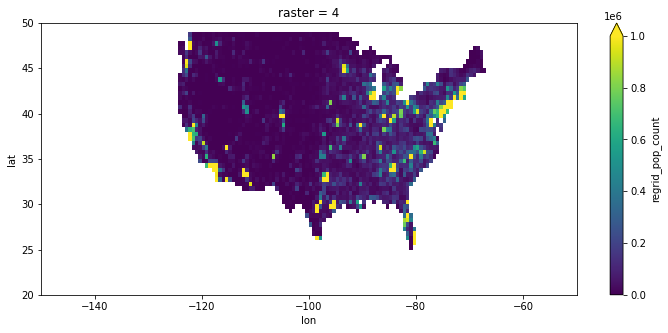

In [19]:
US_land_pop_ds['regrid_pop_count'].plot(figsize = (12,5), vmax = 1000000)
plt.xlim(-150,-50)
plt.ylim(20,50)
print('total US population', US_land_pop_ds['regrid_pop_count'].sum().values)

In [17]:
ds_PM = xr.merge([US_land_pop_ds.interp_like(ds_PM), ds_PM])

In [18]:
ds_o3 = xr.merge([US_land_pop_ds.interp_like(ds_PM), dsO3_hrly])

## CRF From Vohra et. al 2021 for PM

In [37]:
#beta from Vodonos et al. 2018
beta_orig_df = {}
for ids in ['low','mean','high']:
    beta_orig_df[ids] = pd.read_excel('final_data/CRF_Vodonos_data.xls', names = ['PM25','beta'], sheet_name = ids)


In [40]:
zero_row = {}
for ids in ['low','mean','high']:
    zero_row[ids]= pd.DataFrame({'beta':beta_orig_df[ids]['beta'][0], 'PM25':0}, index = {0})


In [68]:
β_ds = {}
for ids in ['low','mean','high']:
    β_ds[ids] = xr.Dataset.from_dataframe(pd.concat([zero_row[ids], beta_orig_df[ids]])).set_index({'index':'PM25'}).rename({'index':'PM25'})
    #interpolate beta onto an even grid
    β_ds[ids] = β_ds[ids] .interp(PM25 = np.arange(0,70,.0001), method = 'linear')
    β_ds[ids]['Δx'] = β_ds[ids]['PM25'].diff(dim = 'PM25')
    #convert percent
    β_ds[ids]['beta'] /= 100.

In [69]:
#mortality data from IHME GBD 2017
obs_mortality = pd.read_csv('../../health_data/global_burden_disease_2017_data/IHME-GBD_2017_DATA-2c4a32b7-1.csv')
obs_mortality = obs_mortality.drop([1,2,3,4,5])

In [79]:
def β_mean_(x0, x1, ids):
    '''calculates the beta mean for PM2.5 CRF'''
    if (x0==x1):
        return β_ds[ids]['beta'].sel(PM25 = x0, method = 'nearest')
    if np.isnan(x0) | np.isnan(x1):
        return(np.nan)
    if x1>x0:
        return((1/(x1-x0))*np.sum((β_ds[ids]['beta']*β_ds[ids]['Δx']).sel(PM25 = slice(x0,x1))))
    if x0>x1:
        #return β_ds['beta'].sel(PM25 = x0, method = 'nearest')
        return((1/(x0-x1))*np.sum((β_ds[ids]['beta']*β_ds[ids]['Δx']).sel(PM25 = slice(x1,x0))))

    
def β_mean(x0, x1,ids):
    '''applies the beta mean calculation to our dataset'''
    return xr.apply_ufunc(
        β_mean_,
        x0,
        x1,
        ids,
        input_core_dims=[[],[],[]],  # list with one entry per arg
        output_dtypes=[float],
        vectorize=True)



def AF(ds, x0, x1, ids):
    '''calculates the attributable fraction for our CRF for PM2.5'''
    return(np.exp(ds[f'β_{ids}']*(x1 - x0))-1)/np.exp(ds[f'β_{ids}']*(x1 - x0))


In [77]:
x0 = ds_PM["PM25"].sel(model_name = 'normal_NA').mean(dim = 'time').compute()
x1 = ds_PM["PM25"].sel(model_name = 'nonuc_NA').mean(dim = 'time').compute()
for ids in ['low','mean','high']:
    ds_PM[f'β_{ids}'] = β_mean(x0, x1, ids) #calculate the beta for each grid box


In [80]:
for ids in ['low','mean','high']:
    ds_PM[f'AF_{ids}'] =  AF(ds_PM, x0, x1, ids) #calculate the attributable fraction for each grid box
    mortality0 = obs_mortality['val']/ds_PM['regrid_pop_count'].sum().values #calculate our initial mortality rate
    ds_PM[f'Δmortality_{ids}'] = ds_PM[f'AF_{ids}']*ds_PM['regrid_pop_count']*mortality0.values #calculate our change in mortality

In [84]:
ds_PM['Δmortality_low'].sum()

<xarray.DataArray 'Δmortality_low' ()>
array(5840.98338194)
Coordinates:
    raster   int32 4
    lev      float64 0.9925

## CRF From Turner 2016 for Ozone

(hazard ratio [HR] per 10 ppb, 1.02; 95% confidence interval [CI], 1.01–1.04) from Turner 2016 (which is used in the latest regulatory impact analysis for CSAPR https://www.epa.gov/sites/production/files/2021-03/documents/revised_csapr_update_ria_final.pdf) 

ΔM≃β_LL×I_OBS×(Δχ×p_aff )   

In [85]:
delta_chi = 10 #ppb
RR = {'low':1.01 , 'mean':1.02, 'high': 1.04} #
β = {}
for ids in ['mean','low','high']:
    β[ids]= np.log(RR[ids])/delta_chi

for lat in ds_o3.lat:
    for lon in ds_o3.lon:
        ds_o3['βm'].loc[{'lat':lat, 'lon':lon}] = np.squeeze(utils.draw_bs(β_normal_dist, size=1))

In [86]:
x0 = ds_o3['SpeciesConc_O3'].sel(model_name = 'normal_NA').sel(time = ds_o3.time.dt.hour.isin([np.arange(10,18)])).isel(lev = 0).mean(dim = 'time').compute()
x1 = ds_o3['SpeciesConc_O3'].sel(model_name = 'nonuc_NA').sel(time = ds_o3.time.dt.hour.isin([np.arange(10,18)])).isel(lev = 0).mean(dim = 'time').compute()
mortality0 = obs_mortality['val']/ds_o3['regrid_pop_count'].sum().values #calculate our initial mortality rate
mol_to_ppb = 1e9
for ids in ['mean','low','high']:
    ds_o3[f'Δmortality_{ids}'] = mol_to_ppb * (x1-x0)*ds_o3['regrid_pop_count']*β[ids]*mortality0.values #calculate our change in mortality

In [87]:
for ids in ['mean','low','high']:

    print(ids, ds_o3[f'Δmortality_{ids}'].sum().values)

mean 2406.4772454375425
low 1209.195346889329
high 4766.223811696578


In [88]:
ds_o3['model_name'] = ds_o3.model_name.astype('str')
ds_PM['model_name'] = ds_PM.model_name.astype('str')

In [89]:
xr.Dataset.to_zarr(ds_o3, './final_data/o3_mortalities.zarr', mode = 'w') #save the dataset 
xr.Dataset.to_zarr(ds_PM, './final_data/pm_mortalities.zarr', mode = 'w') #save the dataset 

# ISORROPIA Data

## Create Dataset

In [3]:
#import GC run data
poll_ds = xr.open_zarr('./data/GC_output.zarr')

#import RH and T dataframe
RH_T_df = pd.read_csv('./data/RH_T.csv', index_col=[0,1])

#subset our ds into just the species we need
species_list = ['SO4','NH3','HNO3','NIT','NH4']
isorropia_ds = poll_ds[species_list]

##### species in ISORROPIA 
SO4, NH3, NO3, Cl, Ca, K, Mg

In [4]:
#create a dataframe for our isorropia monthly mean values for no nuclear and normal cases, indexed by species, location, season

isorropia_dict = {}
for species in species_list:
    isorropia_dict[species]= {}
    for region in utils.lat_lon_dict.keys():
        isorropia_dict[species][region] = {}
        for season in ['DJF','MAM','JJA','SON']:
            data = isorropia_ds.sel(lon = slice(utils.lat_lon_dict[region][0], utils.lat_lon_dict[region][1]), 
                                    lat = slice(utils.lat_lon_dict[region][2],utils.lat_lon_dict[region][3])).groupby('time.season').mean(dim = ['lat','lon','time']).sel(season = season)[species]
            isorropia_dict[species][region][season] = data.values
            
isorropia_df = pd.DataFrame.from_dict({(i,j,k): isorropia_dict[i][j][k] 
                            for i in isorropia_dict.keys() 
                            for j in isorropia_dict[i].keys()
                            for k in isorropia_dict[i][j].keys()},
                            orient='index', columns = isorropia_ds['model_name'].values)

isorropia_df.index = pd.MultiIndex.from_tuples(isorropia_df.index, names = ['Species','Location', 'Season'])

In [5]:
#convert from mol/mol to mol/m3 by multiplying by P/T*R (mol/m3)
stp_p = 101325 #Pa = kg/m/s^2
R = 8.314 #J/K/mol
for species in species_list:
    for region in utils.lat_lon_dict.keys():
            for season in ['DJF','MAM','JJA','SON']:
                isorropia_df.loc[(species,region,season)] *= stp_p/R/RH_T_df.loc[(region,season)]['T']
                #isorropia_df.loc[(species,region,season)]['normal'] *= stp_p/R/RH_T_df.loc[(region,season)]['T']


In [7]:
#convert NIT, NH4, SO4 from ug/m3 to mol/m3
for species in utils.aerosol_species_dict.keys():
    for region in utils.lat_lon_dict.keys():
            for season in ['DJF','MAM','JJA','SON']:
                isorropia_df.loc[(species,region,season)] /= (utils.aerosol_species_dict[species]*1e6)#ug/m3/(#g/mol*#ug/g)

#convert NH3, HNO3 from ppbv to mol/m3
for species in ['NH3','HNO3']:
    for region in utils.lat_lon_dict.keys():
            for season in ['DJF','MAM','JJA','SON']:
                isorropia_df.loc[(species,region,season)] *= stp_p/R/RH_T_df.loc[(region,season)]['T']/1e9


In [8]:
#calculate the total Nitrate and ammonium by molarity
isorropia_df_TNO3 = isorropia_df.loc['HNO3'] + isorropia_df.loc['NIT'] 
isorropia_df_TNH3 = isorropia_df.loc['NH3'] + isorropia_df.loc['NH4'] 

## Run through ISORROPIA
### Only run once to initiate a new ISORROPIA output, otherwise, the output is already made

In [9]:
import os
os.chdir('/net/fs11/d0/emfreese/ISORROPIAIIStandalone')
for model in ['nonuc_model', 'normal_model']:
    for region in ['SE_lat_lon', 'NW_lat_lon', 'NE_lat_lon', 'MW_lat_lon', 'SW_lat_lon']:
            for season in ['DJF','JJA']:
                T_tmp = RH_T_df.loc[(region, season)]['T']
                RH_tmp = RH_T_df.loc[(region, season)]['RH']
                SO4_tmp = isorropia_df.loc['SO4',region,season][model]
                
                os.system(f'mkdir -p {region}_{season}_{model}/')
                os.system(f'cp src/* {region}_{season}_{model}/')
                
                os.chdir(f'{region}_{season}_{model}/')
                print(os.listdir())
                
                cmdprefix = 'cat ISORange.dat | sed -i '
                cmdT = f"-e 's/T(K):       0.0/T(K):       {T_tmp}/' "
                cmdRH = f"-e 's/RH(-):      0.0/RH(-):      {RH_tmp}/' "
                cmdNH3 = f"-e 's/TSO4:       0.0e-9/TSO4:       {SO4_tmp}/' "
                cmdoutput = f"-e 's/Output:     NW_DJF_nonuc_ISOOutput.nc/Output:     ISOOutput_{region}_{season}_{model}_constant_SO4.nc/' "
                cmdsuffix = 'ISORange.dat'
                
                cmd = cmdprefix+cmdT+cmdRH+cmdNH3+cmdoutput+cmdsuffix
                
                os.system(cmd)
                
                os.chdir('../')

os.chdir('../grid_model/ego_nonuclear_project/')

['CREDITS', 'how_to.txt', 'ISORange.dat', 'ISORange_original.dat', 'ISORange_test.dat', 'isorropiaII_main_mod.F', 'isorropiaii_main_mod.mod', 'isorropiaII_main_mod.o', 'Makefile', 'multi_isorropiaII.F90', 'multi_isorropiaII.o', 'runISORROPIA']
['CREDITS', 'how_to.txt', 'ISORange.dat', 'ISORange_original.dat', 'ISORange_test.dat', 'isorropiaII_main_mod.F', 'isorropiaii_main_mod.mod', 'isorropiaII_main_mod.o', 'Makefile', 'multi_isorropiaII.F90', 'multi_isorropiaII.o', 'runISORROPIA']
['CREDITS', 'how_to.txt', 'ISORange.dat', 'ISORange_original.dat', 'ISORange_test.dat', 'isorropiaII_main_mod.F', 'isorropiaii_main_mod.mod', 'isorropiaII_main_mod.o', 'Makefile', 'multi_isorropiaII.F90', 'multi_isorropiaII.o', 'runISORROPIA']
['CREDITS', 'how_to.txt', 'ISORange.dat', 'ISORange_original.dat', 'ISORange_test.dat', 'isorropiaII_main_mod.F', 'isorropiaii_main_mod.mod', 'isorropiaII_main_mod.o', 'Makefile', 'multi_isorropiaII.F90', 'multi_isorropiaII.o', 'runISORROPIA']
['CREDITS', 'how_to.txt'

## Save our dataframe

In [10]:
#### save our data out ####
isorropia_df.to_csv('./data/ISORROPIA_data.csv')